In [1]:
import math
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
from tensorflow.python.framework import ops
from cnn_utils import *

In [2]:
#loading the data
X_train_orig,Y_train_orig,X_test_orig,Y_test_orig,classes=load_dataset()

In [3]:
X_train=X_train_orig/255.
X_test=X_test_orig/255.
Y_train=convert_to_one_hot(Y_train_orig,6).T
Y_test=convert_to_one_hot(Y_test_orig,6).T


In [4]:
def create_placeholder(n_H0,n_W0,n_C0,n_y):
    '''
    Arguments:
    n_H0:-scaler, height of an image
    n_W0:-scaler, width of an image
    n_C0:-scaler, number of channels of the input
    n_y:-scaler, number of classes
    Returns:
    X:-placeholder for the data input of shape [None,n_H0,n_W0,n_C0] and dtype "float"
    Y:-placeholder for the input labels, of shape [None,n_y] and dtype "float"
    
    '''
    X=tf.placeholder(tf.float32,name="X",shape=[None,n_H0,n_W0,n_C0])
    Y=tf.placeholder(tf.float32,name="Y",shape=[None,n_y])
    return X,Y

In [5]:
def initialize_parameters():
    '''
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    '''
    W1=tf.get_variable('W1',[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer())
    W2=tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer())
    parameters={"W1":W1,
               "W2":W2}
    return parameters

In [6]:
def forward_propagation(X,parameters):
    '''
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    '''
    W1=parameters["W1"]
    W2=parameters["W2"]
    Z1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    A1=tf.nn.relu(Z1)
    P1=tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding="SAME")
    Z2=tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    A2=tf.nn.relu(Z2)
    P2=tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding="SAME")
    P2=tf.contrib.layers.flatten(P2)
    Z3=tf.contrib.layers.fully_connected(P2,num_outputs=6,activation_fn=None)
    return Z3

In [7]:
def compute_cost(Z3,Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 6)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    return cost

In [8]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.009,epochs=100,minibatch_size=64,print_cost=True):
    '''
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    '''
    
    ops.reset_default_graph() # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)   # to keep results consistent(tensorflow seed)
    seed=3                  #to keep result consistent (numpy seed)
    (m,n_H0,n_W0,n_C0)=X_train.shape
    n_y=Y_train.shape[1]
    costs=[]
    # create placeholder of the correct shape
    X,Y=create_placeholder(n_H0,n_W0,n_C0,n_y)
    
    # Initialize parameters
    parameters=initialize_parameters()
    # Forward propagation:
    Z3=forward_propagation(X,parameters)
    # Cost function
    cost=compute_cost(Z3,Y)
    # for backpropagation
    optimizer=tf.train.AdamOptimizer(learning_rate).minimize(cost)
    # Initialize all the variables globally
    init=tf.global_variables_initializer()
    # start the session to compute the tensorflow graph
    with tf.Session() as sess:
        #Run the initialization
        sess.run(init)
        # Do the training loop
        for e in range(epochs):
            minibatch_cost=0.
            num_minibatches=int(m/minibatch_size)
            minibatches=random_mini_batches(X_train,Y_train,minibatch_size)
            for minibatch in minibatches:
                (minibatch_X,minibatch_Y)=minibatch
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and e % 5 == 0:
                print ("Cost after epoch %i: %f" % (e, minibatch_cost))
            if print_cost == True and e % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.920022
Cost after epoch 5: 1.451022
Cost after epoch 10: 0.848433
Cost after epoch 15: 0.617150
Cost after epoch 20: 0.499996
Cost after epoch 25: 0.435203
Cost after epoch 30: 0.430464
Cost after epoch 35: 0.353065
Cost after epoch 40: 0.314125
Cost after epoch 45: 0.304294
Cost after epoch 50: 0.247526
Cost after epoch 55: 0.240413
Cost after epoch 60: 0.206014
Cost after epoch 65: 0.170059
Cost after epoch 70: 0

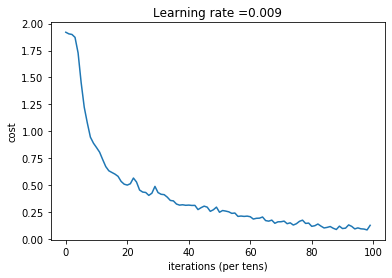

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.96944445
Test Accuracy: 0.85


In [9]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)